In [3]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))
#         pass

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [38]:
# install accelerate==0.15.0 and transformers==4.28.1 if any issues faced while training
#pip show accelerate or pip show transformers to see the library information
import gc
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import evaluate

from transformers import (
    TrainingArguments,
    Trainer,
    ViTImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator,
    pipeline
)

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomRotation,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    Resize,
    ToTensor
)

from datasets import Dataset, Image, ClassLabel

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import ImageFile
from tqdm import tqdm

from pathlib import Path
import os

In [5]:
!pwd

/Users/utsavmdesai/Documents/Coding/CV/mini_projects/Deep Learning/Transformers-AUVSI


In [8]:
file_names = []
labels = []

for file in tqdm(sorted((Path('letters/').glob('*/*.jpg')))):
    label = str(file).split('/')[-1].split('_')[1]
    labels.append(label)
    file_names.append(str(file))
    
print(len(file_names), len(labels))

df = pd.DataFrame.from_dict({"image": file_names, "label": labels})
print(df.shape)

100%|██████████| 23400/23400 [00:00<00:00, 820240.64it/s]

23400 23400
(23400, 2)


In [9]:
df.head()

,image,label
0,letters/A/circle_A_0.jpg,A
1,letters/A/circle_A_1.jpg,A
2,letters/A/circle_A_10.jpg,A
3,letters/A/circle_A_11.jpg,A
4,letters/A/circle_A_12.jpg,A


In [10]:
df['label'].unique()

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'],
      dtype=object)

In [11]:
y = df[['label']]
gc.collect()

40

In [12]:
dataset = Dataset.from_pandas(df).cast_column("image", Image())

In [13]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 23400
})

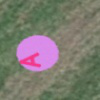

In [14]:
dataset[0]['image']

In [15]:
labels_list = sorted(list(set(labels)))

label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print('Mapping of label to ids', label2id)
print('Mapping of ids to label', id2label)

Mapping of label to ids {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}
Mapping of ids to label {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


In [16]:
ClassLabels = ClassLabel(num_classes = len(labels_list), names = labels_list)

def map_label2id(M):
    M['label'] = ClassLabels.str2int(M['label'])
    return M

dataset = dataset.map(map_label2id, batched = True)

Map:   0%|          | 0/23400 [00:00<?, ? examples/s]

In [17]:
dataset = dataset.cast_column('label', ClassLabels)

dataset = dataset.train_test_split(test_size = 0.2, shuffle = True)  # stratify is used to get a balanced split in the case of unbalanced dataset

train_data = dataset['train']

test_data = dataset['test']

Casting the dataset:   0%|          | 0/23400 [00:00<?, ? examples/s]

In [18]:
model_str = './my_model/'
processor = ViTImageProcessor.from_pretrained(model_str)

image_mean, image_std = processor.image_mean, processor.image_std

size = processor.size['height']
print('Size: ', size)

normalize = Normalize(mean = image_mean, std = image_std)

Size:  224


In [19]:
_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(45),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize
])

_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize
])

def train_transforms(M):
    M['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in M['image']]
    return M
def val_transforms(M):
    M['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in M['image']]
    return M

In [20]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [21]:
def collate_fn(M):
    pixel_values = torch.stack([m['pixel_values'] for m in M])
    labels = torch.tensor([m['label'] for m in M])
    
    return {'pixel_values': pixel_values, 'labels': labels}

In [22]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels = len(labels_list))

model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable = True) / 1e6)

85.81865


In [23]:
accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    label_ids = eval_pred.label_ids
    predicted_labels = predictions.argmax(axis = 1)
    
    acc_score = accuracy.compute(predictions = predicted_labels, references = label_ids)['accuracy']
    
    return {'accuracy': acc_score}

In [24]:
metric_name = 'accuracy'

model_name = 'auvsi_letters_classification'

num_train_epochs = 10

args = TrainingArguments(
    output_dir = model_name,
    logging_dir = './logs',
    num_train_epochs = num_train_epochs,
    evaluation_strategy = 'epoch',
    learning_rate = 2e-6,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 32,
    weight_decay = 0.02,
    warmup_steps = 20,
    remove_unused_columns = False,
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    save_total_limit = 1,
    report_to = 'mlflow'
)

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset = train_data,
    eval_dataset = test_data,
    data_collator = collate_fn,
    compute_metrics = compute_metrics,
    tokenizer = processor
)

In [26]:
trainer.evaluate()

  0%|          | 0/147 [00:00<?, ?it/s]

{'eval_loss': 1.6214048862457275,
 'eval_accuracy': 0.8858974358974359,
 'eval_runtime': 172.3678,
 'eval_samples_per_second': 27.151,
 'eval_steps_per_second': 0.853}

In [ ]:
## last_acc = outputs.metrics['test_accuracy']
while outputs.metrics['test_accuracy'] < 0.9:
    trainer.train()
    last_acc = outputs.metrics['test_accuracy']
    outputs = trainer.predict(test_data)
    print('Current accuracy: ', outputs.metrics)
    if last_acc > outputs.metrics['test_accuracy']:
        print('Accuracy is decreasing. Exiting the while loop!!!')
        break

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.067874,0.810897
2,1.905500,1.980890,0.832265
3,1.905500,1.953757,0.835043


Current accuracy:  {'test_loss': 1.9537572860717773, 'test_accuracy': 0.8350427350427351, 'test_runtime': 40.7, 'test_samples_per_second': 114.988, 'test_steps_per_second': 3.612}


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.832059,0.854487
2,1.672200,1.757915,0.865385
3,1.672200,1.734166,0.869017


Current accuracy:  {'test_loss': 1.734165906906128, 'test_accuracy': 0.869017094017094, 'test_runtime': 40.0212, 'test_samples_per_second': 116.938, 'test_steps_per_second': 3.673}


Epoch,Training Loss,Validation Loss


In [78]:
trainer.evaluate()

  0%|          | 0/147 [00:00<?, ?it/s]

{'eval_loss': 1.6214048862457275,
 'eval_accuracy': 0.8858974358974359,
 'eval_runtime': 173.5313,
 'eval_samples_per_second': 26.969,
 'eval_steps_per_second': 0.847}

In [77]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

  0%|          | 0/147 [00:00<?, ?it/s]

{'test_loss': 1.6214048862457275, 'test_accuracy': 0.8858974358974359, 'test_runtime': 169.1294, 'test_samples_per_second': 27.671, 'test_steps_per_second': 0.869}


In [49]:
trainer.save_model('auvsi_letters_classification')

In [50]:
pipe = pipeline('image-classification', model = "auvsi_letters_classification")

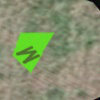

Prediction »»» M
 
 
 


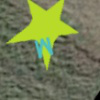

Prediction »»» M
 
 
 


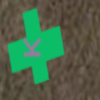

Prediction »»» K
 
 
 


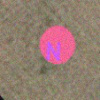

Prediction »»» N
 
 
 


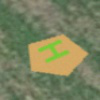

Prediction »»» H
 
 
 


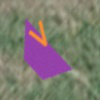

Prediction »»» V
 
 
 


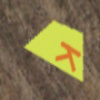

Prediction »»» K
 
 
 


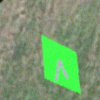

Prediction »»» V
 
 
 


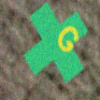

Prediction »»» G
 
 
 


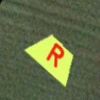

Prediction »»» R
 
 
 


In [81]:
import random
for i in range(10):
    k = random.randint(0, 4679)
    image = test_data[k]['image']
    display(image)
    print('Prediction »»»', pipe(image)[0]['label'])
    print(' ')
    print(' ')
    print(' ')